# Python Methods to Derive a Seasonal Mean from Daymet Data - Reading/Writing netCDF
*Author:  ORNL DAAC*
<br>
*Date:  February 28, 2018*
<br>
*Contact for [ORNL DAAC](https://daac.ornl.gov):  uso@daac.ornl.gov*

**Keywords:  Daymet, Python, netCDF, THREDDS**

## Overview

该项目说明来如何使用Python netCDF4 和 numpy modules 以用N-dimensional array objects处理netCDF file format的数据集. Python numpy array的方法可以打开读取a gridded multidimentional netCDF file也可以按时间范围取其中的子集。这个示例是用了daymet的一个maximum temperature variables数据集 ，该数据集包括daily gridded meteorologic data. 运用该数据集计算了夏季平均最高气温，并将结果存入到新的netcdf文件中。后续示例文档会演示多年数据循环处理.

![](NCSS_GSMNPsubset.png)

## Prerequisites

Python 2.7 or later.
Python modules:  netCDF4, numpy, matplotlib

## Source Data

北美Daymet 数据集空间数据子集 日数据; https://daymet.ornl.gov . 

本例中的空间数据子集从 ORNL DAAC's THREDDS netCDF Subset Service (NCSS)获取. NCSS的指导：https://daymet.ornl.gov/web_services.html .

使用本指导文件 通过下列 HTTP GET NCSS Request URL 下载2015 maximum temperature Daymet subset：

https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1328/2015/daymet_v3_tmax_2015_na.nc4?var=lat&var=lon&var=tmax&north=36.61&west=-85.37&east=-81.29&south=33.57&disableProjSubset=on&horizStride=1&time_start=2015-01-01T12%3A00%3A00Z&time_end=2015-12-31T12%3A00%3A00Z&timeStride=1&accept=netcdf 

2016年数据将上述文件的2015改成2016即可。

https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1328/2016/daymet_v3_tmax_2016_na.nc4?var=lat&var=lon&var=tmax&north=36.61&west=-85.37&east=-81.29&south=33.57&disableProjSubset=on&horizStride=1&time_start=2016-01-01T12%3A00%3A00Z&time_end=2016-12-31T12%3A00%3A00Z&timeStride=1&accept=netcdf 

***

接下来这部分是额外补充的：

首先看看NCS tutorial，看看一般情况下数据如何获取。这一小部分和本文内容不是特别相关，如果不需要批量下载，可以跳过这节。

NASA的EARTHDATA下的ORNL DAAC项目daymet数据的web services允许直接通过带参数的url下载数据。理解这些服务能让我们更好地查询，选择和自动下载数据。有两类下载服务：

- 自动下载网格数据集
- 单个像素提取及文件自动下载

这里我要要下载的是全美网格的数据，所以看第一种。

**Scripts to Automate Gridded Subsets of Daymet Data**：

NetCDF Subset Service (NCSS) 使用的是RESTful API来允许下载指定坐标范围内的netcdf数据集子集。交互的请求可以通过编程来实现自动化，包括通过扩展URL的参数构建HTTP请求和提交。

### Understanding the NetCDF Subset Service (NCSS)

看NCSS的步骤：

1. Open [THREDDS](https://thredds.daac.ornl.gov/thredds/catalogs/ornldaac/Regional_and_Global_Data/DAYMET_COLLECTIONS/DAYMET_COLLECTIONS.html) for Daily Weather Data
2. Click the folder 2015
3. Click the file Daymet v3 daily minimum temperature for na (2015)
4. Click the Netcdf Subset

可以看到daymet的各年数据如[网页](https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/1328/catalog.html)所示

上述步骤如下图所示：

![](THREDDS_fileselection.png)

具体选择到NCSS后，有[网页](https://thredds.daac.ornl.gov/thredds/ncss/grid/ornldaac/1328/2015/daymet_v3_dayl_2015_hawaii.nc4/dataset.html)如下提供了GUI界面可供配置URL读取该nc文件的子集。

![](NCSS_gui.png)

### Evaluating the URL request

从上图看到，页面底部有NCSS生成的URL，可以直接copy该url到浏览器中下载数据。改变时间和空间数据范围就可以轻松下载其他符合索引要求的数据。

Daymet数据是在Lambert Conformal Conic (LCC) Projection system下定义的。具体的投影信息可在daymet网站上查看：https://daymet.ornl.gov/overview  在数据下也可以看到：https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/1328/1980/catalog.html?dataset=1328/1980/daymet_v3_tmin_1980_na.nc4

Proj4 = "+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

这个应该就是准确的坐标系信息，如果要做坐标转换，需要以这个为准。

批量获取数据的代码地址：https://github.com/ornldaac/gridded_subset_example_script

因为这里是用python的，所以就直接看看用python调用这些url的情况。有几种方式可以选择：

- 在python中调用wget
- 在python中调用上述批量获取数据代码
- 直接使用netcdf-python中的远程读取代码直接读取netcdf数据

先尝试在python中调用wget下载一年的数据。python中调用wget需要提前安装好wget,

``` code
pip install wget
```

目前 Daymet NCSS 有 6GB的单文件请求下载限制。如果数据量超过该大小限制会返回an error message。

比如选择美国大陆，经纬度范围在https://epsg.io/ 网站wgs84坐标下查询。用west=-132，east=-60.00， north=51.00，south=22.00，这时候就会直接报错，无法下载。

所以最好还是明确好自己要读取的数据的范围，然后再下载（比如north=50.00,west=-104.00,east=-81.00,south=35)）。最好还是时间选短一些，然后每个shapefile内每天求平均的时候再读取数据。或者手动下载一份全美的也可以。

这里就使用接下来的例子

In [3]:
import wget
url_pattern="http://thredds.daac.ornl.gov/thredds/ncss/grid/ornldaac/1328/{year}/daymet_v3_{par}_{year}_na.nc4?var=lat&var=lon&var={par}&north={north}&west={west}&east={east}&south={south}&horizStride=1&time_start={year}-01-01T12:00:00Z&time_end={year}-12-30T12:00:00Z&timeStride=1&accept=netcdf"
url=url_pattern.format(year=1980,par='tmin', north=36.61,west=-85.37,east=-81.29,south=33.57)
print(url)
wget.download(url)

http://thredds.daac.ornl.gov/thredds/ncss/grid/ornldaac/1328/1980/daymet_v3_tmin_1980_na.nc4?var=lat&var=lon&var=tmin&north=36.61&west=-85.37&east=-81.29&south=33.57&horizStride=1&time_start=1980-01-01T12:00:00Z&time_end=1980-12-30T12:00:00Z&timeStride=1&accept=netcdf
-1 / unknown

'daymet_v3_tmin_1980_na.nc4.nc'

虽然NCSS上有大小限制，不过貌似可以直接通过https服务器使用url下载，用https这种方式下载下来的就是nc4格式的（其他方式下载的数据都会被加上nc格式，也是很奇怪）。所以暂时就使用这个下载了。各个变量类型：

tmax	Daily maximum 2-meter air temperature (°C)
tmin	Daily minimum 2-meter air temperature (°C)
prcp	Daily total precipitation (mm/day)
srad	Incident shortwave radiation flux density (W/m2)
vp	Water vapor pressure (Pa)
swe	Snow water equivalent (kg/m2)
dayl	Duration of the daylight period (seconds/day)

下面给出一个例子，下载整年的没有空间范围要求的：

In [27]:
import wget
url_pattern="https://thredds.daac.ornl.gov/thredds/fileServer/ornldaac/1328/{year}/daymet_v3_{par}_{year}_na.nc4"
url=url_pattern.format(year=1980,par='tmax')
# 下载到指定文件夹内
path=r'data'
print(url)
wget.download(url,path)

https://thredds.daac.ornl.gov/thredds/fileServer/ornldaac/1328/1980/daymet_v3_tmax_1980_na.nc4


'data/daymet_v3_tmax_1980_na.nc4'

然后试试python爬虫方式下载数据。

接下来使用netcdf-python的远程读取数据方式。选择每日数据单独计算的时候，采用这种方式也可行。使用opendap的方式读取数据和前面wget下载数据的方式不同，比如https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/1328/1980/catalog.html?dataset=1328/1980/daymet_v3_tmin_1980_na.nc4   在此网址下，点击opendap的选项可以看到合适的url，并且这里选择url参数的方式也不一样，具体可以在网站上勾选variables选项下的各个变量，看看url的变化。

In [12]:
#!/usr/bin/env python
# Read data from an opendap server
import netCDF4
import time
# 可以用x和y选择一个范围，注意官方网站上给出的url是有问题的，形如：“?x[0:1:5],y[0:1:5]”，实际上下面的url才是正确的，得有“=”
url_pattern="https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1328/{year}/daymet_v3_{par}_{year}_na.nc4?x=[0:1:50],y=[0:1:50]"
url=url_pattern.format(year=1980,par='tmin')
# 比如时间的范围：选两天的数据看看
# url_pattern="https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1328/{year}/daymet_v3_{par}_{year}_na.nc4"
# url=url_pattern.format(year=1980,par='tmin')
print(url)
# create a dataset object
start = time.time()
dataset = netCDF4.Dataset(url)
end = time.time()
print('计算耗时：', '%.7f' % (end - start))
# lookup a variable
print('netCDF file format:' + ' ' + dataset.file_format)  # displays the netCDF file format
print(dataset) 
print( 'netCDF variables:')
print( dataset.variables.keys())

https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1328/1980/daymet_v3_tmin_1980_na.nc4?x=[0:1:50],y=[0:1:50]
计算耗时： 0.4446609
netCDF file format: NETCDF4_CLASSIC
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format DAP2):
    start_year: 1980
    source: Daymet Software Version 3.0
    Version_software: Daymet Software Version 3.0
    Version_data: Daymet Data Version 3.0
    Conventions: CF-1.6
    citation: Please see http://daymet.ornl.gov/ for current Daymet data citation information
    references: Please see http://daymet.ornl.gov/ for current information on Daymet references
    DODS_EXTRA.Unlimited_Dimension: time
    dimensions(sizes): x(7814)
    variables(dimensions): float32 x(x)
    groups: 

netCDF variables:
odict_keys(['x'])


补充说明：

变量类型有：

tmax	Daily maximum 2-meter air temperature (°C)
tmin	Daily minimum 2-meter air temperature (°C)
prcp	Daily total precipitation (mm/day)
srad	Incident shortwave radiation flux density (W/m2)
vp	Water vapor pressure (Pa)
swe	Snow water equivalent (kg/m2)
dayl	Duration of the daylight period (seconds/day)

***

## Procedure

The procedure is outlined in this Jupyter IPython Notebook, [daymet_netCDF_season-avg.ipynb](https://github.com/ornldaac/daymet_netcdf_season-avg/blob/master/daymet_netCDF_season-avg.ipynb). 
<br>
A follow-on tutorial that demonstrates automating multiple years is found at: [daymet_netCDF_season-avg-loopyrs.ipynb](https://github.com/ornldaac/daymet_netcdf_season-avg/blob/master/daymet_netcdf_season-avg-loopyrs.ipynb)
<br>
This tutorial is presented in the NASA Earthdata Webinar ["NetCD What? An Ecologists Guide to Working with Daymet and Other netCDF Formatted Data"](https://www.youtube.com/watch?v=Y_f0L62TleE&feature=youtu.be).

以下代码的使用前提是安装好netcdf相关软件。

### 1. Load python modules for working with netCDF files.
NumPy is the fundamental package for scientific computing within Python and provides an N-dimensional array object suitable for multidimensional netCDF files.
netCDF4 is a Python interface to the netCDF version 4 library.  netCDF4 relies on NumPy arrays and requires Python 2.7 or later.
Load additional packages for plotting.

In [1]:
import numpy as np  
from netCDF4 import Dataset

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams

### 2.  Read, explore, and create netCDF files.  
In the next several steps, we'll read, explore, and create a new netCDF file.  Using a spatial subset of Daymet maximum temperature netCDF data, we'll explore the netCDF file.  This script assumes the nc files are in the python script location. We'll take a temperal subset of the netCDF file, create an average grid from that subset and write the average into a new netCDF file.  We'll use the input netCDF file as a guide to creating a new netCDF file.
We'll use the netCDF4 Dataset() method to open the subset and create a new netCDF file. 

In [2]:
daymet_ds = Dataset('daymet_v3_tmax_2015_na.nc4.nc', 'r') # reads the netCDF file
tmaxJJA_2015_write = Dataset('tmaxJJA_2015.nc', 'w', format='NETCDF4') # creating a file in which to write new climatology

Here, we'll use Python dictionary calls to explore aspects of the Daymet netCDF file. We can look at the file format of the netCDF file, the dimensions and variables of the file, and specific attributes for each variable.  

In [3]:
print('netCDF file format:' + ' ' + daymet_ds.file_format)  # displays the netCDF file format

print( '\n')
print( 'netCDF dimensions:')
print( daymet_ds.dimensions.keys()) # python dictionary calls allow viewing of the netCDF file's dimensions
print( '\n')
print( 'time dimension:')
print( daymet_ds.dimensions['time'])  # view specifics of the time dimension
print( 'x dimension:')
print(daymet_ds.dimensions['x'])

# 注意netcdf中的变量都是二维的，每个经纬度都是对应每个二维网格的，所以维度都是二维的。而维度变量是一维的
print( 'lon varaibles:')
print( daymet_ds.variables['lon'],'\n')

print( 'netCDF variables:')
print( daymet_ds.variables.keys())  # View the netCDF file's variables 
print( '\n')
print( 'tmax variable and attributes:')
print( daymet_ds.variables['tmax']) # view the variable and its associated attributes

netCDF file format: NETCDF3_CLASSIC


netCDF dimensions:
odict_keys(['y', 'x', 'time'])


time dimension:
<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 365

x dimension:
<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 417

lon varaibles:
<class 'netCDF4._netCDF4.Variable'>
float32 lon(y, x)
    units: degrees_east
    long_name: longitude coordinate
    standard_name: longitude
    _ChunkSizes: [1010  977]
    _CoordinateAxisType: Lon
    coordinates: y x 
    grid_mapping: lambert_conformal_conic
unlimited dimensions: 
current shape = (390, 417)
filling on, default _FillValue of 9.969209968386869e+36 used
 

netCDF variables:
odict_keys(['lat', 'y', 'x', 'lambert_conformal_conic', 'lon', 'tmax', 'time'])


tmax variable and attributes:
<class 'netCDF4._netCDF4.Variable'>
float32 tmax(time, y, x)
    _FillValue: -9999.0
    long_name: daily maximum temperature
    units: degrees C
    missing_value: -9999.0
    coordinates: time y x 
    grid_mapping:

### 3.  Read a variable into a NumPy array
We'll read the main variable of interest (maximum temperature) into a NumPy array so we can use Python functions to perform some arithmatic.

In [18]:
tmax = daymet_ds.variables['tmax'][:]  # Reads the whole array
type(tmax)

numpy.ma.core.MaskedArray

Look at the shape of the array and values of tmax as a np array

In [26]:
print(tmax.shape) # In Daymet (and netCDF 3 files), the unlimited dimension, time in this case, is the leftmost dimension
print(tmax)  

# 简单索引下tmax数据，注意时间维度是第几维度
index=[(0,1),(2,2),(3,3)]
index=np.array(index)
print(index)
index=index.T
print(index)
print(tmax[0][index[0]][index[1]])

(365, 390, 417)
[[[ 1.5  1.5  1.5 ...  5.   5.   5. ]
  [ 1.5  1.5  1.5 ...  5.   5.   5. ]
  [ 1.5  1.5  1.5 ...  5.   5.   5. ]
  ...
  [10.   9.5  9.5 ... 14.  14.  14. ]
  [10.   9.5  9.5 ... 14.  14.  14. ]
  [ 9.5  9.5  9.5 ... 14.  14.  14. ]]

 [[ 4.   3.5  3.5 ...  9.   9.   9. ]
  [ 4.   4.   4.  ...  9.   9.   9. ]
  [ 4.   4.   4.  ...  9.   9.5  9. ]
  ...
  [10.  10.  10.  ... 15.5 16.  15.5]
  [10.  10.  10.  ... 15.5 15.5 15.5]
  [10.  10.  10.  ... 15.5 15.5 15.5]]

 [[10.5 10.5 10.5 ... 11.5 12.  11.5]
  [10.5 10.5 10.5 ... 11.5 12.  12. ]
  [10.5 10.5 10.5 ... 11.5 12.  12. ]
  ...
  [16.5 16.  16.  ... 18.  18.  18. ]
  [16.  16.  16.  ... 18.  18.  18. ]
  [16.  16.  16.  ... 18.  18.  18. ]]

 ...

 [[19.  19.  19.  ... 17.  17.  17. ]
  [19.  19.  19.  ... 17.  17.  17. ]
  [19.  19.  19.  ... 17.  17.  17. ]
  ...
  [19.  19.  19.  ... 26.5 26.5 26.5]
  [19.  19.  19.  ... 26.5 26.5 26.5]
  [19.  19.  19.  ... 26.5 26.5 26.5]]

 [[11.  11.  11.  ... 16.5 16.5 16

IndexError: index 3 is out of bounds for axis 0 with size 3

While we're reading variables, let's copy other variables important variables from the netCDF files to numpy arrays.  We'll use these later to populate the new temperature summary file.
Name them *_daymet_ds as a reminder of where they're from.

In [7]:
lat_daymet_ds = daymet_ds.variables['lat'][:]
lon_daymet_ds = daymet_ds.variables['lon'][:]
x_daymet_ds = daymet_ds.variables['x'][:]
y_daymet_ds = daymet_ds.variables['y'][:]
print(type(lat_daymet_ds))
print(type(lon_daymet_ds))
print(type(x_daymet_ds))
print(type(y_daymet_ds))
# 经纬度是二维的
print(lat_daymet_ds[0][0])
print(lon_daymet_ds[0][0])
# 维度变量是一维的
print(x_daymet_ds[0])
print(y_daymet_ds[0])

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
37.250504
-85.23009
1249.75
-446.0


### 4. Create a summer average of the GSMNP spatial subset.
To create a temporal average from the daily data, subset the tmax variable to a time set of interest.
For example, a summer, or JuneJulyAugust, subset would be yearday 151 - 243.  

In [34]:
tmax_JJA = daymet_ds.variables['tmax'][151:243 , :, :]  # We're not subsetting the x or y dimension.

In [35]:
tmax_JJA.shape

(92, 390, 417)

Derive the mean using the NumPy package.  The numpy mean function computes the arithmetic mean along a specifed axis.

In [36]:
tmax_JJA_mean_comp = np.mean(tmax_JJA, axis=0, keepdims=True)

In [37]:
print(tmax_JJA_mean_comp.shape)
print(tmax_JJA_mean_comp)

(1, 390, 417)
[[[29.097826 28.945652 28.945652 ... 29.956522 30.10326  30.043478]
  [29.163044 29.157608 29.048914 ... 29.967392 30.097826 30.108696]
  [29.168478 29.108696 29.288044 ... 30.048914 30.14674  30.119566]
  ...
  [31.902174 31.72826  31.711956 ... 33.684784 33.684784 33.679348]
  [31.858696 31.690218 31.711956 ... 33.679348 33.679348 33.673912]
  [31.72826  31.527174 31.625    ... 33.66848  33.66848  33.663044]]]


(1, 390, 417)
(390, 417)
(1, 390, 417)


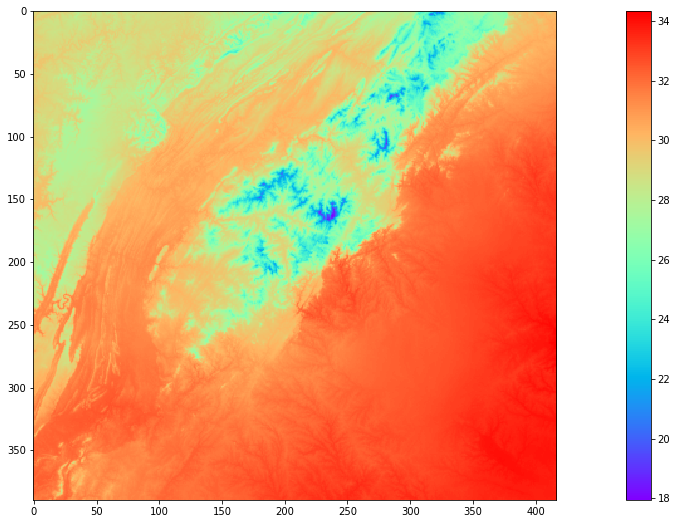

In [38]:
print(tmax_JJA_mean_comp.shape)
tmax_JJA_mean_comp.shape=(390,417)  # decrease a dimension in order to plot
print(tmax_JJA_mean_comp.shape)
%matplotlib inline
plt.rcParams["figure.figsize"] = (25,9)
imgplot = plt.imshow(tmax_JJA_mean_comp, cmap='rainbow')
plt.colorbar()
tmax_JJA_mean_comp.shape=(1,390,417) # add the (time) dimension back in for further analysis
print(tmax_JJA_mean_comp.shape)

### 5. Write to the output netCDF file; create dimensions and variables to write the JJA average output
netCDF files define the sizes of variables in terms of dimensions.  In the process of creating a netCDF file, before any variables can be created, the dimensions they use must first be created and defined. In this case, the x and y dimension will be the same size as the Daymet tmax input dataset, so we'll call the Python len function to copy the size from the input file. Use the createDimension method to create new dimensions. The first argument supplies the dimension name.  The second argument is the size of the dimension. Time will be unlimited, so set to None. Unlimited dimensions can be appended to.

In [39]:
x_len = len(daymet_ds.dimensions['x'])
y_len = len(daymet_ds.dimensions['y'])

In [40]:
tmaxJJA_2015_write.createDimension('x', x_len)
tmaxJJA_2015_write.createDimension('y', y_len)
tmaxJJA_2015_write.createDimension('time', None)

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0

Use the createVariable method to create a variable in the new netCDF file to hold the tmax_JJA_mean.
The first argument supplies the variable name, the second argument is the datatype (eg. f4 is 32 bit float), the third argument sets the shape.
If needed, variable names can be changed using the renameVariable method of a Dataset instance.

In [41]:
tmax_JJA_mean_var = tmaxJJA_2015_write.createVariable('tmax_JJA_mean', 'f4', ('time','y','x'), fill_value=-9999)

Add attributes to the tmax_JJA_mean variable.
Attributes can be deleted from a netCDF Dataset, or Variable using the python del statement.

In [42]:
tmax_JJA_mean_var.units = 'degrees C'
tmax_JJA_mean_var.coordinate = 'y x'
tmax_JJA_mean_var.grid_mapping = 'lambert_conformal_conic'
tmax_JJA_mean_var.cell_methods = 'area: mean time: minimum within days time: mean over days'
tmax_JJA_mean_var.long_name = 'summer mean of daily maximum temperature'

Add the rest of the necessary variables and attributes to the netCDF climatology file, (use the original Daymet file as a guide).

In [43]:
lat_var = tmaxJJA_2015_write.createVariable('lat', 'f4', ('y','x'))
lon_var = tmaxJJA_2015_write.createVariable('lon', 'f4', ('y','x'))
x_var = tmaxJJA_2015_write.createVariable('x', 'f4', ('x'))
y_var = tmaxJJA_2015_write.createVariable('y', 'f4', ('y'))
proj_var = tmaxJJA_2015_write.createVariable('lambert_conformal_conic', 'u2') # u2:16bit unsigned integer, no dimensions
time_var = tmaxJJA_2015_write.createVariable('time', 'f4', ('time'))

# add attributes for each variable
lat_var.units = 'degrees_north'
lat_var.long_name = 'latitude coordinate'
lat_var.standard_name = 'latitude'

lon_var.units = 'degrees_east'
lon_var.long_name = 'longitude coordinate'
lon_var.standard_name = 'longitude'

x_var.units = 'km'
x_var.long_name = 'x coordinate of projection'
x_var.standard_name = 'projection_x_coordinate'

y_var.units = 'km'
y_var.long_name = 'y coordinate of projection'
y_var.standard_name = 'projection_y_coordinate'

proj_var.grid_mapping_name = 'lambert_conformal_conic'
proj_var.longitude_of_central_meridian = -100.0
proj_var.latitude_of_projection_origin = 42.5
proj_var.false_easting = 0.0
proj_var.false_northing = 0.0
proj_var.standard_parallel = (25.,  60.)
proj_var.semi_major_axis = 6378137.0
proj_var.inverse_flattening = 298.257223563

time_var.long_name = 'time'
time_var.calendar = 'standard'
time_var.units = 'days since 1980_01_01 00:00:00 UTC'


### 6. Write data into the new netCDF file variables
Write the JJA array into the netCDF file along with the latitute, longitude, x, and y values.

In [44]:
tmax_JJA_mean_var[:] = tmax_JJA_mean_comp
lat_var[:,:] = lat_daymet_ds
lon_var[:,:] = lon_daymet_ds
x_var[:] = x_daymet_ds
y_var[:] = y_daymet_ds
time_var[:] = 12981.5

In [45]:
print('dims:')
print(tmaxJJA_2015_write.dimensions.keys())
print('\n')
print('vars:')
print(tmaxJJA_2015_write.variables.keys())
print('\n')
tmaxJJA_values = tmaxJJA_2015_write['tmax_JJA_mean'][:]
print('tmaxJJA_values:')
print(tmaxJJA_values)

dims:
odict_keys(['x', 'y', 'time'])


vars:
odict_keys(['tmax_JJA_mean', 'lat', 'lon', 'x', 'y', 'lambert_conformal_conic', 'time'])


tmaxJJA_values:
[[[29.097826 28.945652 28.945652 ... 29.956522 30.10326  30.043478]
  [29.163044 29.157608 29.048914 ... 29.967392 30.097826 30.108696]
  [29.168478 29.108696 29.288044 ... 30.048914 30.14674  30.119566]
  ...
  [31.902174 31.72826  31.711956 ... 33.684784 33.684784 33.679348]
  [31.858696 31.690218 31.711956 ... 33.679348 33.679348 33.673912]
  [31.72826  31.527174 31.625    ... 33.66848  33.66848  33.663044]]]


In [46]:
# Close and write the new netCDF file.  Congratulations.  You've just created a new netCDF file with the JJA_mean as a variable.  
daymet_ds.close()
tmaxJJA_2015_write.close()

### 7.  Next Steps
The next tutorial [daymet_netcdf_season-avg-loopyrs](https://github.com/ornldaac/daymet_netcdf_season-avg/blob/master/daymet_netcdf_season-avg-loopyrs.ipynb) will demonstrate a condensed procedure toward multi-year automation.